### Income and Outlays Monthly Data

In [1]:
%config Completer.use_jedi = False
import sys
import json
sys.path.append('../src')

import uschartbook.config

from uschartbook.config import *
from uschartbook.utils import *

### Download NIPA tables

In [2]:
# Request data from BEA API
for tbl in ['20600', '20806', '20804']:
    r = bea_api_nipa([f'T{tbl}'], bea_key, freq='M')
    s = nipa_series_codes(json.loads(r[0][2])['BEAAPI']['Results'])
    data = json.loads(r[0][2])['BEAAPI']['Results']
    date = lambda x: pd.to_datetime(x.TimePeriod.str.replace('M', '-') + '-01')
    df = pd.DataFrame({c: (pd.DataFrame(data['Data']).assign(date = date)
                             .query('SeriesCode == @c')
                             .set_index('date')['DataValue'].sort_index())
                       for c in s.keys()}).replace(',','', regex=True).astype(float)
    df.to_csv(data_dir / f'nipa{tbl}.csv', index_label='date')

### Income measures per capita

In [3]:
s = ['A261RC', 'A262RC']
df = nipa_df(retrieve_table('T11000')['Data'], s).sort_index()
df['NDI'] = (df['A261RC'] - df['A262RC'])

# deflator
pce = pd.read_csv(data_dir / 'nipa20804.csv', 
                 index_col='date', parse_dates=True)['DPCERG']
pce = (pce.iloc[-1] / pce)
pceq = pce.resample('QS').mean()

# DPI and PI, monthly, and population
cols = ['A067RC', 'A065RC', 'B230RC']
dfm = (pd.read_csv(data_dir/'nipa20600.csv', index_col='date', 
                  parse_dates=True)[cols])
pop = dfm['B230RC']
popq = dfm['B230RC'].resample('QS').mean()

# Per capita real monthly
d = {'A065RC': 'PI', 'A067RC': 'DPI'}
pcm = (dfm[d.keys()].divide(pop, axis=0).multiply(pce, axis=0)
       .rename(d, axis=1)).rolling(3).mean()

#pcm.to_csv(data_dir / 'pc_inc_mon.csv', index_label='date')
# Per capita real quarterly
pcq = ((df['NDI'] / popq) * pceq).dropna()
pcq.name = 'NDI'
pcq.index = pcq.index + pd.DateOffset(days=45)
#pcq.to_csv(data_dir / 'pc_inc_qtr.csv', index_label='date')

In [2]:
#pcm.plot()

### After-tax income growth

In [5]:
df = pd.read_csv(data_dir/'nipa20600.csv', index_col='date', 
                 parse_dates=True)
data = (df['A229RX'].pct_change(12) * 100).dropna()
data.to_csv(data_dir / 'rdpigrowth.csv', header=['rdpi'], 
            index_label='date')
color = 'blue!80!cyan'
node = end_node(data, color, date='m')
write_txt(text_dir / 'rdpi_node.txt', node)

ltdate = dtxt(data.index[-1])['mon1']
ltval = data.iloc[-1]
prdate = dtxt(data.index[-2])['mon1']
prval = data.iloc[-2]
prdate2 = dtxt(data.index[-13])['mon1']
prval2 = data.iloc[-13]
ltavg = data.iloc[-13:].mean()
ltavg2 = data.loc['2017-03-01': '2020-02-01'].mean()
url = 'https://www.bea.gov/data/income-saving/personal-income'
text = (f'The Bureau of Economic Analysis \href{{{url}}}{{report}} '+
        'an inflation-adjusted one-year change in after-tax income '+
        f'per person of {ltval:.1f} percent in {ltdate}, {prval:.1f} '+
        f'percent in {prdate}, and {prval2:.1f} percent in '+
        f'{prdate2} {c_line(color)}. Over the past year, the measure '+
        f'has averaged {ltavg:.1f} percent. During the three years '+
        'before the COVID-19 pandemic, per capita after-tax income '+
        f'grew at an average annual rate of {ltavg2:.1f} percent.')
write_txt(text_dir / 'rdpigrowth.txt', text)
print(text)

The Bureau of Economic Analysis \href{https://www.bea.gov/data/income-saving/personal-income}{report} an inflation-adjusted one-year change in after-tax income per person of 3.0 percent in September 2023, 3.2 percent in August 2023, and -2.7 percent in September 2022 (see {\color{blue!80!cyan}\textbf{---}}). Over the past year, the measure has averaged 1.9 percent. During the three years before the COVID-19 pandemic, per capita after-tax income grew at an average annual rate of 2.7 percent.


### Monthly consumer spending growth

In [6]:
pop = (pd.read_csv(data_dir/'nipa20600.csv', index_col='date', 
                  parse_dates=True)['B230RC'])
pr = pd.read_csv(data_dir / 'nipa20804.csv', 
                 index_col='date', parse_dates=True)['DPCERG']
npce = (pd.read_csv(data_dir/'nipa20600.csv', index_col='date', 
                  parse_dates=True)['DPCERC'])
df = ((npce / pr / pop).pct_change(12) * 100).dropna().rename('rpcepop')
df.to_csv(data_dir / 'pcegrowth.csv', index_label='date')
color = 'green!70!olive!60!black'
node = end_node(df, color, date='m')
write_txt(text_dir / 'pcegrowth_node.txt', node)

ltdt = dtxt(df.index[-1])['mon1']
ltpc = f'\${(npce / pop).iloc[-1] * 1000:,.0f} per capita'
ltval  = df.iloc[-1]
pydate = dtxt(df.index[-13])['mon1']
pyval = df.iloc[-13]
compare = compare_text(ltval, pyval, [0.1, 0.5, 2.0])
url = 'https://www.bea.gov/data/consumer-spending/main'
pyrt = value_text(pyval, 'increase_of', threshold=0.1)
ltrt = value_text(ltval, threshold=0.1)

text = (f'Consumer spending is also \href{{{url}}}{{reported}}'+
        f' on a monthly basis. In {ltdt}, consumer spending totals '+
        f'{ltpc}, on an annualized basis. Inflation- and population-'+
        f'adjusted consumer spending {ltrt} over the year ending {ltdt} '+
        f'{c_line(color)}, {compare} the previous year rate ({pyrt} '+
        f'over the year ending {pydate}). ')
write_txt(text_dir / 'pcegrowth.txt', text)
print(text)

Consumer spending is also \href{https://www.bea.gov/data/consumer-spending/main}{reported} on a monthly basis. In September 2023, consumer spending totals \$56,166 per capita, on an annualized basis. Inflation- and population-adjusted consumer spending increased 1.9 percent over the year ending September 2023 (see {\color{green!70!olive!60!black}\textbf{---}}), slightly above the previous year rate (an increase of 1.5 percent over the year ending September 2022). 


### Personal saving rate

In [7]:
df = pd.read_csv(data_dir/'nipa20600.csv', index_col='date', 
                 parse_dates=True)
data = df.loc['1989':, 'A072RC']
data.to_csv(data_dir / 'psavert.csv', index_label='date')
datelt = dtxt(data.index[-1])['mon1']
latest = data.iloc[-1]
ch_covid = latest - data.loc['2020-02-01']
color = 'red'
node = end_node(data, color, date='m', 
                offset=0.35)
write_txt(text_dir / 'psavert_node.txt', node)

txt = value_text(ch_covid, ptype='pp', adj='total')
url = 'https://www.bea.gov/data/income-saving/personal-saving-rate'
text = (f'In {datelt}, the Bureau of Economic Analysis '+
        f'\href{{{url}}}{{report}} a personal saving rate of '+
        f'{latest:.1f} percent {c_line(color)}. '+
        f'The personal saving rate {txt} since February 2020.')
write_txt(text_dir / 'psavert.txt', text)
print(text)

In September 2023, the Bureau of Economic Analysis \href{https://www.bea.gov/data/income-saving/personal-saving-rate}{report} a personal saving rate of 3.4 percent (see {\color{red}\textbf{---}}). The personal saving rate decreased by a total of 4.3 percentage points since February 2020.


### Personal Income

In [13]:
series = {
 'TOTAL': '\hspace{0.5mm}Personal Income (Pre-Tax Income)',
 'LABOR': '\hspace{-2mm}\cbox{green!55!blue!72!black}Labor',
 'A034RC': '\hspace{3mm} Wages \& Salaries',
 'A038RC': '\hspace{3mm} Supplements to Wages \& Salaries',
 'CAPITAL': '\hspace{-2mm}\cbox{yellow!85!orange!88!white}Capital',
 'A041RC': "\hspace{3mm} Proprietors' Income",
 'A048RC': '\hspace{3mm} Rental Income',
 'A064RC': '\hspace{3mm} Personal Interest Income',
 'B703RC': '\hspace{3mm} Personal Dividend Income',
 'TRANSFER': '\hspace{-2mm}\cbox{cyan!90!blue!90!white}Net Government Benefits',
 'A063RC': '\hspace{2mm} Government Social Benefits',
 'W823RC': '\hspace{3mm} Social Security',
 'W824RC': '\hspace{3mm} Medicare',
 'W729RC': '\hspace{3mm} Medicaid',
 'W825RC': '\hspace{3mm} Unemployment Insurance',
 'W826RC': "\hspace{3mm} Veterans' Benefits",
 'W827RC': '\hspace{3mm} Other',
 'A061RC': '\hspace{2mm} Less: Social Insurance Contributions'}

In [9]:
df = (pd.read_csv(data_dir/'nipa20600.csv', index_col='date', 
                 parse_dates=True)        
        .assign(CAPITAL = lambda x: x['A041RC'] + x['A048RC'] + x['W210RC'],
                TRANSFER = lambda x: x['A577RC'] - x['A061RC'],
                A061RC = lambda x: - x['A061RC'])
        .rename({'A065RC': 'TOTAL', 'A033RC': 'LABOR'}, axis=1))
df.to_csv(data_dir / 'pi_raw.csv', index_label='date')

In [31]:
df = pd.read_csv(data_dir / 'pi_raw.csv', index_col='date', 
                 parse_dates=True)

pce = pd.read_csv(data_dir / 'nipa20804.csv', 
                 index_col='date', parse_dates=True)['DPCERG']
pce = (pce.iloc[-1] / pce)

pop = df['B230RC']

data = (df.div(pop, axis=0).multiply(pce, axis=0))
cols = ['LABOR', 'CAPITAL', 'TRANSFER']
(data.loc['1989-01-01':,cols]
     .to_csv(data_dir / 'pi_levels.csv', index_label='date'))

tbl = ((data[series.keys()].rename(series, axis=1)
            .iloc[[-1, -2, -3, -13, -49]].T * 1000)
            .applymap('{:,.0f}'.format))

tbl.columns = [dtxt(c)['mon6'] for c in tbl.columns]
tbl.index.name = ''
tbl.iloc[0, 0] = f'\${tbl.iloc[0, 0]}'
tbl.to_csv(data_dir / 'pi_levels.tex', sep='&', 
           lineterminator='\\\ ', quotechar=' ')

ld = data.index[-1]
ltdate = dtxt(data.index[-1])['mon1']
totval = data.loc[ld, 'TOTAL'] * 1000
labval = data.loc[ld, 'LABOR'] * 1000
capval = data.loc[ld, 'CAPITAL'] * 1000
welval = data.loc[ld, 'TRANSFER'] * 1000
mark = ' (see \\tikz \draw[black, fill=black!20!white] (2.5pt,4pt) circle (2pt);)'
text = (f'In {ltdate}, annualized personal income is '+
        f'\${totval:,.0f} per capita {mark}. Labor income totals \${labval:,.0f} '+
        f'per person, capital and proprietor income is \${capval:,.0f} '+
        f'per person, and net government benefits total \${welval:,.0f} '+
        'per person. ')
write_txt(text_dir / 'pi_levels_basic.txt', text)
write_txt(text_dir / 'pi_date.txt', ltdate)
print(text)

In September 2023, annualized personal income is \$69,014 per capita  (see \tikz \draw[black, fill=black!20!white] (2.5pt,4pt) circle (2pt);). Labor income totals \$42,956 per person, capital and proprietor income is \$19,304 per person, and net government benefits total \$6,754 per person. 


In [30]:
# End Nodes
sdf = data[cols].iloc[-1]
height = ((sdf.cumsum() - (sdf / 2) + 4)).to_dict()
val = sdf.to_dict()
dtp = dtxt(data.index[-1] + pd.DateOffset(months=2))['datetime2']
nodes = [f'\\absnode{{{{{dtp}}}}}{{{height[i]}}}{{\scriptsize {val[i]:.1f}}}' 
         for i in cols]

dt = dtxt(data.index[-1])['mon6'].replace(' ', ' \\\\ ')
ldt = dtxt(data.index[-1])['datetime2']
lvt = sdf.sum()
node = (f'\\node[label={{[align=left]90:{{\scriptsize {dt}: '+
        f'\\\\ \scriptsize \ {lvt:.1f}}}}}, '+
        'circle, draw=black, fill=black!20!white, inner sep=1.4pt] at '+
        f'(axis cs:{ldt}, {lvt}) {{}};')
nodetext = '\n'.join(nodes + [node])
write_txt(text_dir / 'pi_level_nodes.txt', nodetext)

In [12]:
# Recent data for wage summary chart
df = pd.read_csv(data_dir / 'pi_raw.csv', index_col='date', 
                 parse_dates=True)

# Nonfarm payrolls
nfp = pd.read_csv(data_dir / 'ces_raw.csv', index_col='date', 
                 parse_dates=True)['CES0000000001']

res = (df['A034RC'] / nfp).dropna().pct_change(12) * 100

cpi = pd.read_csv(data_dir / 'cpi.csv', 
                 index_col='date', parse_dates=True)['ALL_S']
cpidt = cpi.index[-73]
data = res.rolling(3).mean().loc[cpidt:].to_frame().rename({0: 'COE'}, axis=1)
data.to_csv(data_dir / 'coe_growth_recent.csv', 
                        index_label='date')

### Income, Outlays, Savings overview

In [19]:
# Income outlays and savings, overview
df = pd.read_csv(data_dir / 'pi_raw.csv', index_col='date', 
                 parse_dates=True)

pce = pd.read_csv(data_dir / 'nipa20804.csv', 
                 index_col='date', parse_dates=True)['DPCERG']
pce = (pce.iloc[-1] / pce)

pop = df['B230RC']

data = (df.div(pop, axis=0).multiply(pce, axis=0))

series2 = {'A067RC': 'DPI',
           'DPCERC': 'PCE',
           'A071RC': 'PSAVE'}
df2 = data.loc['1989':].rename(series2, axis=1)[series2.values()]
df2.to_csv(data_dir / 'inc_out_save.csv', index_label='date')

ltdate = dtxt(df2.index[-1])['mon1']
value = df['A067RC'].iloc[-1] / 1_000_000
value = f'\${value:.1f} trillion'
valuepc = df2['DPI'].iloc[-1] * 1000
valuepc = f'\${valuepc:,.0f}'
pcevalue = df['DPCERC'].iloc[-1] / 1_000_000
pcevalue = f'\${pcevalue:.1f} trillion'
pcevaluepc = df2['PCE'].iloc[-1] * 1000
pcevaluepc = f'\${pcevaluepc:,.0f}'
savevalue = df['A071RC'].iloc[-1] / 1_000_000
savevalue = f'\${savevalue:.2f} trillion'
savevaluepc = df2['PSAVE'].iloc[-1] * 1000
savevaluepc = f'\${savevaluepc:,.0f}'

text = ('In the national accounts, disposable personal income, '+
        'or \\textbf{after-tax income}, totals '+
        f'{value}, on an annualized basis, in {ltdate}, '+
        f'equivalent to {valuepc} per person '+
        '(see {\color{blue!75!black}\\textbf{---}}). Personal '+
        f'consumption expenditures, or \\textbf{{consumer spending}}, totals '+
        f'{pcevalue} in {ltdate}, or {pcevaluepc} per person '+
        '(see {\color{orange}\\textbf{---}}). \\textbf{Personal saving}, '+
        'calculated as after-tax income minus consumer spending '+
        'and other outlays such as interest payments, '+
        f'totals {savevalue}, or {savevaluepc} per person '+
        '(see {\color{green!80!blue}\\textbf{---}}). ')
write_txt(text_dir / 'inc_out_save.txt', text)
print(text)

series3 = {
 'TOTAL': '\hspace{1mm}Personal Income',
 'W055RC': '\hspace{2mm}Personal Current Taxes',
 'A067RC': '\hspace{-1mm} {\color{blue!75!black}\\textbf{---}} \ After-Tax Income',
 'A068RC': '\hspace{3mm} {\ Personal Outlays}',
 'DPCERC': '\hspace{3mm} {\color{orange}\\textbf{---}} \ Consumer Spending', 
 'B069RC': '\hspace{6mm} {\ Interest Payments}',
 'A071RC': '\hspace{0.5mm} {\color{green!80!blue}\\textbf{---}} \ Personal Saving'}

tbl = ((data[series3.keys()].rename(series3, axis=1)
            .iloc[[-1, -2, -3, -4, -13, -37]].T * 1000)
            .applymap('{:,.0f}'.format))

tbl.columns = [dtxt(c)['mon6'] for c in tbl.columns]
tbl.index.name = ''
tbl.iloc[0, 0] = f'\${tbl.iloc[0, 0]}'
tbl.to_csv(data_dir / 'inc_out_save_levels.tex', sep='&', 
           lineterminator='\\\ ', quotechar=' ')

In the national accounts, disposable personal income, or \textbf{after-tax income}, totals \$20.3 trillion, on an annualized basis, in September 2023, equivalent to \$60,556 per person (see {\color{blue!75!black}\textbf{---}}). Personal consumption expenditures, or \textbf{consumer spending}, totals \$18.9 trillion in September 2023, or \$56,166 per person (see {\color{orange}\textbf{---}}). \textbf{Personal saving}, calculated as after-tax income minus consumer spending and other outlays such as interest payments, totals \$0.69 trillion, or \$2,049 per person (see {\color{green!80!blue}\textbf{---}}). 


### Detailed information on spending by type

In [20]:
years = ','.join(map(str, range(1988, 2024)))
url = (f'https://apps.bea.gov/api/data/?&UserID={bea_key}'+
        '&method=GetData&datasetname=NIUnderlyingDetail&'+
        'TableName=U20405&Frequency=M&'+
       f'Year={years}&ResultFormat=json')
r = requests.get(url).json()
data = pd.DataFrame(r['BEAAPI']['Results']['Data'])
data['DataValue'] = data['DataValue'].str.replace(',', '').astype('int')
df = data.groupby(['TimePeriod', 'SeriesCode'])['DataValue'].mean().unstack()
df.columns.name = ''
df.index = (df.reset_index().TimePeriod
            .apply(lambda x: pd.to_datetime(x, format='%YM%m')).rename('date'))
df.to_csv(data_dir / 'nipaU20405.csv')

### Gross Labor Income

In [21]:
# Calculate Gross Labor Income
start = '2017-01-01'
coe = (pd.read_csv(data_dir/'nipa20600.csv', index_col='date', 
                   parse_dates=True)['A033RC']
       .pct_change(12) * 100).rename('BEA')
coe.loc[start:].to_csv(data_dir / 'gli_coe.csv', index_label='date')

# Text
cline = c_line('orange!80!yellow')
ltdt = dtxt(coe.index[-1])['mon1']
prdt = dtxt(coe.index[-13])['mon1']
text = (f'The monthly data on compensation of employees from BEA {cline} '+
        f'shows one-year gross labor income growth of {coe.iloc[-1]:.1f} '+
        f'percent in {ltdt}, and {coe.iloc[-13]:.1f} percent in '+
        f'{prdt}, one-year prior. ')
write_txt(text_dir / 'gli_coe.txt', text)
print(text)

The monthly data on compensation of employees from BEA (see {\color{orange!80!yellow}\textbf{---}}) shows one-year gross labor income growth of 5.2 percent in September 2023, and 7.4 percent in September 2022, one-year prior. 


### Major Government Programs

In [22]:
data = pd.read_csv(data_dir/'nipa20600.csv', index_col='date', 
                 parse_dates=True)
d = {'W823RC': 'SS', 'W824RC': 'Medicare', 'W729RC': 'Medicaid'}
df = data[d.keys()].rename(d, axis=1)

# GDP monthly estimate
gdp = pd.read_csv(data_dir/'gdp_monthly.csv', index_col='date', 
                  parse_dates=True)
res = (df.divide(gdp['A191RC'], axis=0)) * 100
res.dropna().loc['1989':].to_csv(data_dir / 'prog_exp.csv', 
                                 index_label='date')

In [23]:
ltdt = dtxt(res.dropna().index[-1])['mon1']
csh10 = value_text(res.loc['2010'].sum(axis=1).mean(), 'plain')
cshlt = value_text(res.dropna().iloc[-1].sum(), 'plain')
sssh = value_text(res.SS.dropna().iloc[-1].sum(), 'plain')
aresh = value_text(res.Medicare.dropna().iloc[-1].sum(), 'plain')
aidsh = value_text(res.Medicaid.dropna().iloc[-1].sum(), 'plain')
text = ('Payments to Social Security beneficiaries, combined with '+
        'government spending on Medicare and Medicaid, comprise '+
        f'{csh10} of GDP in 2010. In the latest data, covering '+
        f'{ltdt}, these programs combined are equivalent to {cshlt} '+
        'of GDP. As of July 2023, Social Security benefits are '+
        f'{sssh} of GDP, and government spending on Medicare and '+
        f'Medicaid are {aresh} and {aidsh} of GDP, respectively.')
write_txt(text_dir / 'prog_exp.txt', text)
print(text)

Payments to Social Security beneficiaries, combined with government spending on Medicare and Medicaid, comprise 10.7 percent of GDP in 2010. In the latest data, covering September 2023, these programs combined are equivalent to 11.3 percent of GDP. As of July 2023, Social Security benefits are 4.8 percent of GDP, and government spending on Medicare and Medicaid are 3.4 percent and 3.1 percent of GDP, respectively.


### Personal Income and Net Domestic Income

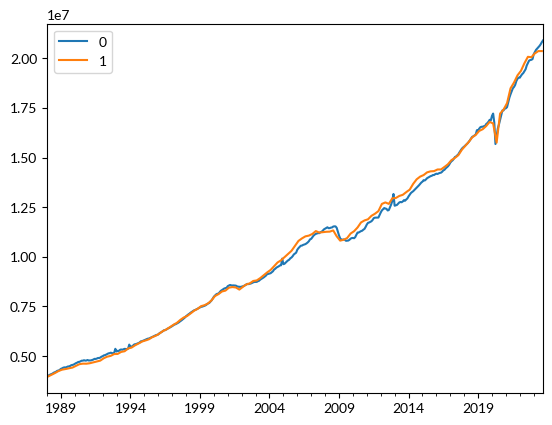

In [3]:
df = pd.read_csv(data_dir / 'pi_raw.csv', index_col='date', 
                 parse_dates=True)
df.index = df.index.to_period('M')
mpi = df[['LABOR', 'CAPITAL']].sum(axis=1)
labsh = df['LABOR'] / mpi

s = ['A261RC', 'A4002C', 'A262RC', 'W056RC', 'A107RC']
df = nipa_df(retrieve_table('T11000')['Data'], s).sort_index()
df.index = (df.index + pd.DateOffset(days=45)).to_period('M')
# Calculate indirect taxes net of transfers
df['indirect'] = df['W056RC'] - df['A107RC']
# Income minus depreciation and indirect taxes
ndi = (df['A261RC'] - df['A262RC'] - df['indirect'])
ndi = ndi.resample('M').interpolate()
pd.concat([mpi, ndi], axis=1).plot();

<AxesSubplot: >

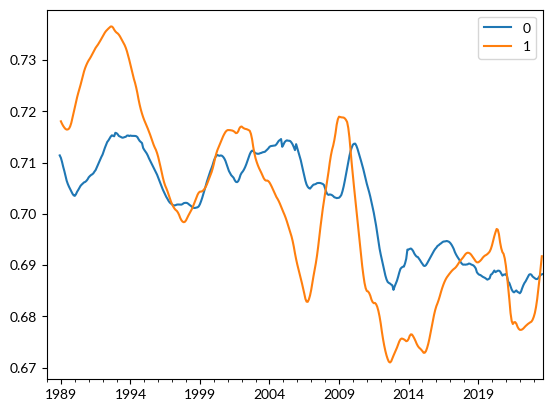

In [5]:
labsh2 = df['A4002C'].resample('M').interpolate() / ndi
pd.concat([labsh, labsh2], axis=1).rolling(12).mean().plot()

### Real Per Capita Consumer Spending and Related Contributors

In [129]:
def growth_contrib_3m3m(df, total_column):
    '''
    Return the contribution to total change (3M/3M) for each column
    '''
    ch = df.rolling(3).mean() - df.shift(3).rolling(3).mean()
    prtot = df[total_column].shift(3).rolling(3).mean()
    gr = ch.divide(prtot, axis=0)
    return (((gr + 1) ** 4) - 1) * 100 # Annualized growth rate

In [165]:
df = (pd.read_csv(data_dir / 'nipa20600.csv', 
                 index_col='date', parse_dates=True)
        .assign(OTHER = lambda x: -(x['A068RC'] - x['DPCERC']),
                SAVING = lambda x: -x['A071RC'])
        .rename({'A067RC': 'INCOME', 'DPCERC': 'SPENDING'}, axis=1))
# population
pop = df['B230RC']

# deflator
pce = pd.read_csv(data_dir / 'nipa20804.csv', 
                 index_col='date', parse_dates=True)['DPCERG']
defl = (pce.iloc[-1] / pce)

# 3M/3M growth rate
df['REAL'] = df['SPENDING'] * defl
df['REAL_PC'] = df['REAL'] / pop
srs = df[['SPENDING', 'REAL', 'REAL_PC']]
res = m3rate(srs)
res['INFL_CONTR'] = res['SPENDING'] - res['REAL']
res['POP_CONTR'] = res['REAL'] - res['REAL_PC']
res['label'] = [dt.strftime('%b\\\%Y') if dt.month == 1 
                  else dt.strftime('%b') if dt.month in [7]
                  else '' for dt in res.index]
keep_col = ['POP_CONTR', 'INFL_CONTR', 'REAL_PC', 'SPENDING', 'label']
res[keep_col].iloc[-19:].to_csv(data_dir / 'npcedecomp3m.csv', 
                                index_label='date')
node = end_node(res['SPENDING'], 'black', date='m', offset=0.35, 
                xoffset=0.05, size=1.4)
write_txt(text_dir / 'npce_decomp3m_node.txt', node)

# Real per capita
s = ['INCOME', 'SPENDING', 'OTHER', 'SAVING']
rpc = (df[s].divide(pop, axis=0).multiply(defl, axis=0))
ch = growth_contrib_3m3m(rpc, 'SPENDING').dropna().round(2)
ch['label'] = [dt.strftime('%b\\\%Y') if dt.month == 1 
                  else dt.strftime('%b') if dt.month in [7]
                  else '' for dt in ch.index]
ch.iloc[-19:].to_csv(data_dir / 'exp_inc_save_mon.csv')
node = end_node(ch['SPENDING'], 'black', date='m', offset=0.35, 
                xoffset=0.05, size=1.4)
write_txt(text_dir / 'exp_inc_save_mon_node.txt', node)

In [162]:
# Text
ltdt = dtxt(ch.index[-1])['mon1']
thresh = 0.1
expch = value_text(ch.SPENDING.iloc[-1], 'plain')
incval = ch.INCOME.iloc[-1]
inc = ('Higher income' if incval > 0.1 
       else 'Lower income' if incval < -0.1 
       else 'Income')
incch = value_text(incval, 'contribution', ptype='pp', threshold=thresh)
savval = ch.SAVING.iloc[-1]
sav = ('reduced saving' if savval > 0.1 
       else 'increased saving' if savval < -0.1 
       else 'saving')
savch = value_text(savval, 'contribution', ptype='pp', threshold=thresh)
othval = ch.OTHER.iloc[-1]
oth = ('increases in other outlays' if othval < -0.1 
       else 'decreases in other outlays' if othval > 0.1 
       else 'other outlays')
othch = value_text(othval, 'contribution', ptype='pp', threshold=thresh)

# Other outlays
cmpdt = '2022-01-01'
n = (rpc.index[-1] - pd.to_datetime(cmpdt)).days / 365.25
chtot = (((((rpc.iloc[-1] - rpc.loc[cmpdt]) / rpc.SPENDING.loc[cmpdt]) + 1)
          ** (1/n)) - 1) * 100
oth2 = ('increases in other outlays' if chtot.OTHER < -0.1 
       else 'decreases in other outlays' if chtot.OTHER > 0.1 
       else 'other outlays')
othch2 = (value_text(chtot.OTHER, adj='inflation', ptype='pp',
                     threshold=thresh, obj='plural')
          .replace('the inflation rate', 'consumer spending'))
text = ('Real per capita consumer spending over the past three months '+
        'compared with the previous three months shows annualized growth '+
        f'of {expch} in {ltdt}. {inc} {incch}, {sav} {savch}, and '+
        f'{oth} {othch}.\n\n Higher interest rates, which count as '+
        'other outlays, can eat into consumer spending. Since the start of '+
        f'2022, {oth2} have {othch2} per year.')
write_txt(text_dir / 'exp_inc_save_mon.txt', text)
print(text)

Real per capita consumer spending over the past three months compared with the previous three months shows annualized growth of 3.4 percent in September 2023. Lower income subtracted 1.7 percentage points, reduced saving contributed six percentage points, and increases in other outlays subtracted 0.8 percentage point.

 Higher interest rates, which count as other outlays, can eat into consumer spending. Since the start of 2022, increases in other outlays have reduced consumer spending by 0.8 percentage point per year.


In [187]:
rpcgr = pd.DataFrame()
rpcgr['RPC3M'] = m3rate(df['REAL_PC'])
rpcgr['RPC12M'] = (df['REAL_PC'].pct_change(12) * 100).dropna()
# End node
colors = {'RPC3M': 'blue!40!cyan!90!white', 'RPC12M': 'blue!50!black'} 
adj = node_adj(rpcgr.iloc[-19:])
date = {n: None for n, c in colors.items()}
smax = rpcgr.iloc[-1].idxmax()
adj[smax] += 0.35
date[smax] = 'm'
size = {'RPC3M': 1.1, 'RPC12M': 1.3} 
nodes = '\n'.join([end_node(rpcgr[n], c, date=date[n], 
                            offset=adj[n], size=size[n]) 
                   for n,c in colors.items()])
write_txt(text_dir / 'npcegr_nodes.txt', nodes)

rpcgr['label'] = [dt.strftime('%b\\\%Y') if dt.month == 1 
                  else dt.strftime('%b') if dt.month in [7]
                  else '' for dt in rpcgr.index]
rpcgr.iloc[-19:].to_csv(data_dir / 'npcegr.csv', 
                                index_label='date')

In [231]:
# Text for 3M/3M nominal decomp
ltdt = dtxt(res.index[-1])['mon1']
nomch = value_text(res.SPENDING.iloc[-1], adj='annual')
rpcch = value_text(res.REAL_PC.iloc[-1], 'plain')
infch = value_text(res.INFL_CONTR.iloc[-1], 'contribution')
popch = value_text(res.POP_CONTR.iloc[-1], 'contribution', 
                   casual=True)

text = ('Using this measure, nominal consumer spending '+
        f'{nomch} in {ltdt}. Real per capita growth was '+
        f'{rpcch}, inflation {infch}, '+
        f'and population growth {popch}.')
write_txt(text_dir / 'rpcpce_3m_decomp.txt', text)
print(text)

# Text for real per capita recent growth
ch12lt = value_text(rpcgr['RPC12M'].iloc[-1])
tdf = (pd.concat([rpcgr.iloc[-13].to_frame().T, rpcgr.iloc[-2:]])
         .drop('label', axis=1))
prval12 = prval_comp(tdf.RPC12M)
ch3lt = value_text(rpcgr['RPC3M'].iloc[-1], 'plain')
ch3pr = value_text(rpcgr['RPC3M'].iloc[-2], 'plain')
ch3py = value_text(rpcgr['RPC3M'].iloc[-13], 'plain')
dates = date_list(rpcgr)
ltmo = dtxt(rpcgr.index[-1])['mon3']
cl3 = c_line('blue!50!black')
cl12 = c_line('blue!40!cyan!90!white')
text = (f'Over the 12 months ending {ltdt}, real per capita '+
        f'consumer spending {ch12lt}, following {prval12} {cl12}.'+
        f'\n\n The three month growth rate (3M/3M) is {ch3lt} in '+
        f'{ltmo}, {ch3pr} in {dates[1]}, and {ch3py} one year '+
        f'prior {cl3}.')
write_txt(text_dir / 'rpcpce_ltgr.txt', text)
print(text)

Using this measure, nominal consumer spending increased at an annual rate of seven percent in September 2023. Real per capita growth was 3.4 percent, inflation contributed three percent, and population growth added 0.6 percent.
Over the 12 months ending September 2023, real per capita consumer spending increased 1.9 percent, following increases of 1.7 percent in August and 1.5 percent in September 2022 (see {\color{blue!40!cyan!90!white}\textbf{---}}).

 The three month growth rate (3M/3M) is 3.4 percent in September, 2.7 percent in August, and one percent one year prior (see {\color{blue!50!black}\textbf{---}}).
